# Tire Degradation Prediction Model - Week 5

## Overview
This notebook implements advanced models to predict tire degradation in Formula 1 races. Since tire degradation is not strictly linear and depends on multiple factors (compound type, track temperature, driving style, etc.), we'll use sequence models like LSTM to capture these complex patterns.

## Approach
1. **Data Exploration**
   - Analyze the relationship between lap times and tire age
   - Visualize performance degradation patterns by compound
   - Determine how to quantify "degradation" (lap time delta or derived metric)

2. **Feature Engineering**
   - Create a derived tire degradation metric
   - Organize data into sequential format for LSTM
   - Normalize features appropriately
   - Create sliding windows of previous laps to predict future performance

3. **Model Development**
   - **Primary Model**: LSTM network to predict degradation trajectory
   - **Alternative Model**: XGBoost with quantile regression for uncertainty estimation

4. **Evaluation & Visualization**
   - Compare predicted vs. actual degradation curves
   - Analyze performance across different compounds and race conditions
   - Create interactive Plotly visualizations of degradation patterns

5. **Implementation Details**
   - Sequence length: 5 laps (input) → predict next 3-5 laps
   - Features: Tire age, compound, lap time trends, fuel load
   - Target: Derived degradation metric or direct lap time prediction

## Expected Outcomes
- Trained model to predict tire performance over extended stints
- Uncertainty bounds for degradation predictions (10th, 50th, 90th percentiles)
- Interactive visualization of degradation curves by compound

---

## 1. Importing Necessary Libraries and Creatind New Directories

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os



In [22]:
# Import utility functions from our module
from ML_utils.lap_prediction import compound_colors, compound_names

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create output directories if they don't exist
os.makedirs('../../outputs/week5', exist_ok=True)
os.makedirs('../../models/week5', exist_ok=True)

---

## 2. Loading Dataframes

In [23]:
data = pd.read_csv("../../outputs/week3/lap_prediction_data.csv")
print("\nRegular data sample:")
display(data.head())


Regular data sample:


,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber
0,0,83.935,1.0,256.0,261.0,276.0,275.0,1.0,1.0,0,9,2,1.0,0.9848,1
1,1,80.402,1.0,252.0,257.0,276.0,295.0,1.0,2.0,0,9,2,2.0,0.9697,1
2,2,80.499,1.0,249.0,256.0,276.0,297.0,1.0,3.0,0,9,2,3.0,0.9545,1
3,3,80.346,1.0,255.0,256.0,276.0,300.0,1.0,4.0,0,9,2,4.0,0.9394,1
4,4,80.283,1.0,254.0,256.0,277.0,301.0,1.0,5.0,0,9,2,5.0,0.9242,1


In [24]:
seq_data = pd.read_csv("../../outputs/week3/sequential_lap_prediction_data.csv")
print("\nSequential data sample:")
display(seq_data.head())


Sequential data sample:


,Unnamed: 0.1,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,...,Prev_SpeedI2,Prev_SpeedFL,Prev_SpeedST,Prev_TyreAge,LapTime_Delta,SpeedI1_Delta,SpeedI2_Delta,SpeedFL_Delta,SpeedST_Delta,LapTime_Trend
0,1,1.0,80.402,1.0,252.0,257.0,276.0,295.00,1.0,2.0,...,261.0,276.0,275.0,1.0,-3.533,-4.0,-4.0,0.0,20.00,0.000
1,2,2.0,80.499,1.0,249.0,256.0,276.0,297.00,1.0,3.0,...,257.0,276.0,295.0,2.0,0.097,-3.0,-1.0,0.0,2.00,3.630
2,3,3.0,80.346,1.0,255.0,256.0,276.0,300.00,1.0,4.0,...,256.0,276.0,297.0,3.0,-0.153,6.0,0.0,0.0,3.00,-0.250
3,4,4.0,80.283,1.0,254.0,256.0,277.0,301.00,1.0,5.0,...,256.0,276.0,300.0,4.0,-0.063,-1.0,0.0,1.0,1.00,0.090
4,5,5.0,80.402,1.0,255.0,253.0,276.0,309.85,1.0,6.0,...,256.0,277.0,301.0,5.0,0.119,1.0,-3.0,-1.0,8.85,0.182


In [25]:
# Display basic information
print("Basic dataset information:")
print(f"Regular data shape: {data.shape}")
print(f"Sequential data shape: {seq_data.shape}")

Basic dataset information:
Regular data shape: (1180, 15)
Sequential data shape: (1118, 28)


---

## 3. Locating Tire Related Columns


In [26]:
# Check for tire-related columns
tire_columns = ['CompoundID', 'TyreAge']
print(f"\nTire-related columns: {tire_columns}")




Tire-related columns: ['CompoundID', 'TyreAge']


In [27]:
# Summary statistics for tire-related columns
print("\nTire-related statistics:")
display(data[tire_columns].describe())


Tire-related statistics:


,CompoundID,TyreAge
count,1180.000000,1180.000000
mean,2.188136,13.760169
std,0.800887,8.002074
min,1.000000,1.000000
25%,2.000000,7.000000
50%,2.000000,13.000000
75%,3.000000,19.000000
max,3.000000,50.000000


---

## 4. Compound Mappings

In [28]:
# Print compound mappings for reference
print("\nCompound mappings:")
print(f"Compound names: {compound_names}")
print(f"Compound colors: {compound_colors}")


Compound mappings:
Compound names: {1: 'SOFT', 2: 'MEDIUM', 3: 'HARD', 4: 'INTERMEDIATE', 5: 'WET'}
Compound colors: {1: 'red', 2: 'yellow', 3: 'gray', 4: 'green', 5: 'blue'}


---

## 5. Analyzing Relationship between Tire Age and Lap Time by compound

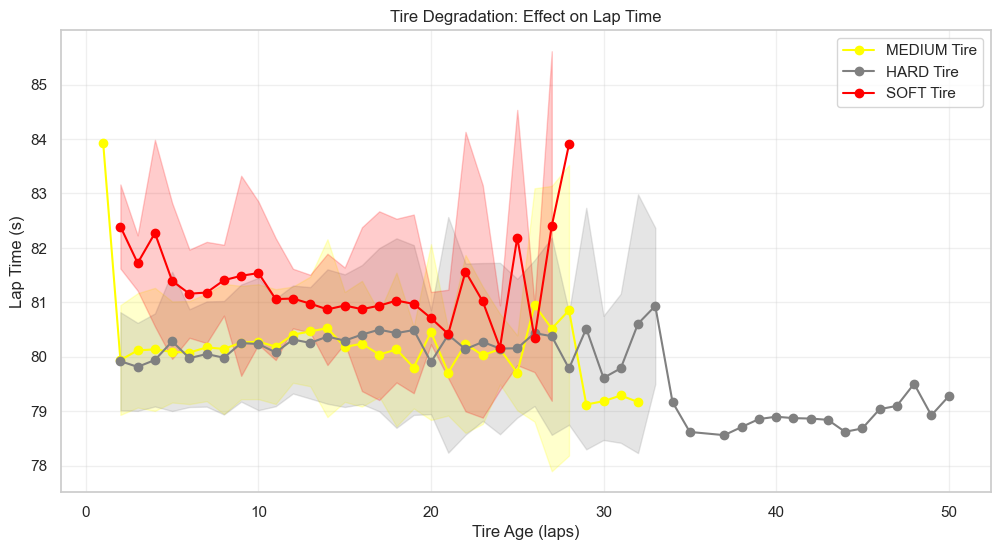

In [29]:
# Visualize the relationship between tire age and lap time by compound
plt.figure(figsize=(12, 6))

# Group by compound and tire age
for compound_id in data['CompoundID'].unique():
    subset = data[data['CompoundID'] == compound_id]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')['LapTime'].agg(['mean', 'std', 'count']).reset_index()
    
    # Only plot if we have enough data points
    if len(agg_data) > 1:
        color = compound_colors.get(compound_id, 'black')
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
                 color=color, label=f'{compound_name} Tire')
        
        # Add error bands (standard deviation)
        if 'std' in agg_data.columns:
            plt.fill_between(agg_data['TyreAge'], 
                            agg_data['mean'] - agg_data['std'], 
                            agg_data['mean'] + agg_data['std'],
                            color=color, alpha=0.2)

plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tire Degradation: Effect on Lap Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_curve.png')
plt.show()

---

## 6. Exploring Lap Times Deltas and Tire Ages

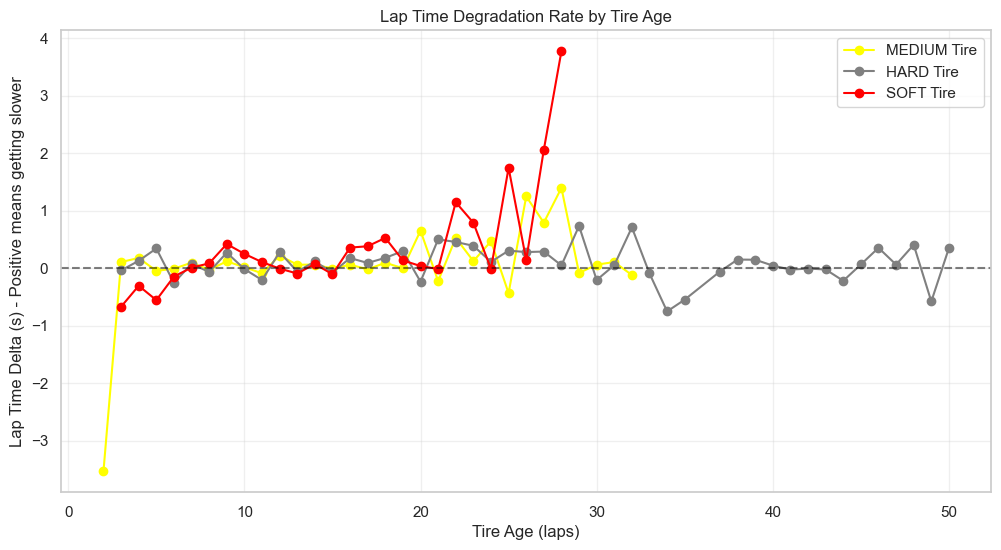

In [30]:
# Explore lap time deltas as tire ages
if 'LapTime_Delta' in seq_data.columns:
    plt.figure(figsize=(12, 6))
    
    for compound_id in seq_data['CompoundID'].unique():
        subset = seq_data[seq_data['CompoundID'] == compound_id]
        
        # Aggregate by tire age
        agg_data = subset.groupby('TyreAge')['LapTime_Delta'].mean().reset_index()
        
        # Only plot if we have enough data points
        if len(agg_data) > 1:
            color = compound_colors.get(compound_id, 'black')
            compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
            
            plt.plot(agg_data['TyreAge'], agg_data['LapTime_Delta'], 'o-', 
                     color=color, label=f'{compound_name} Tire')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Lap Time Delta (s) - Positive means getting slower')
    plt.title('Lap Time Degradation Rate by Tire Age')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../../outputs/week5/tire_deg_rate.png')
    plt.show()

---

## 7. Exploring if Tire Age affects Speed in different Sectors

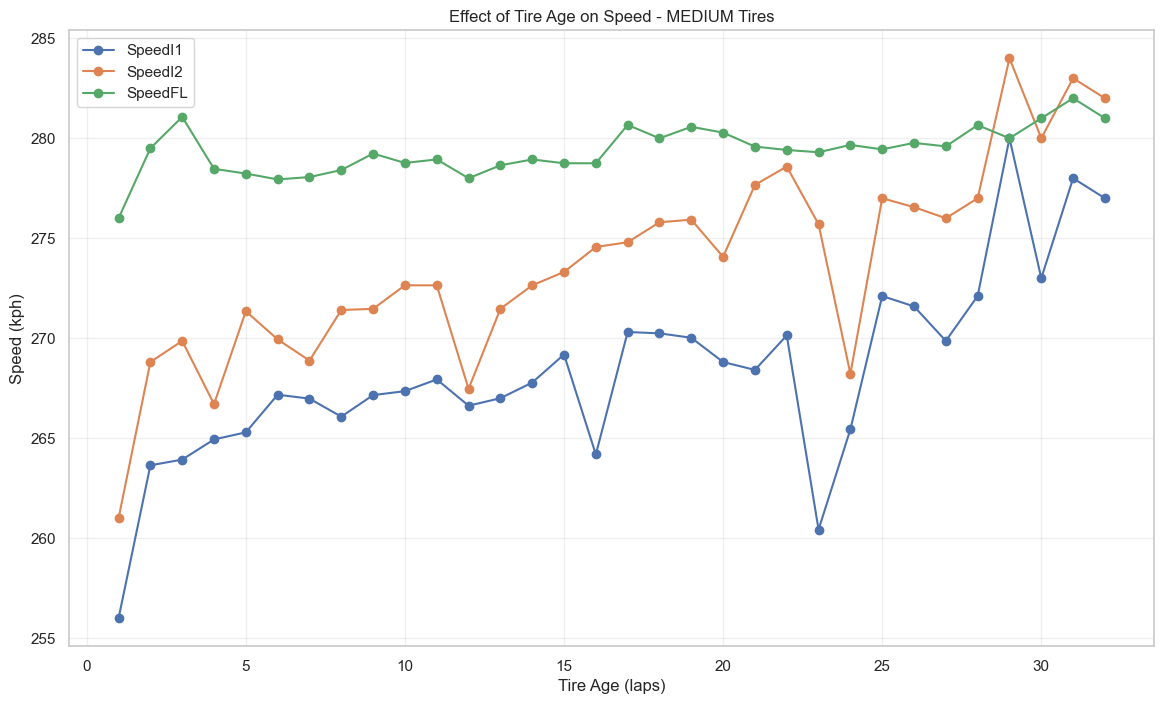

In [31]:
# Look at how tire age affects speed in different sectors
speed_columns = ['SpeedI1', 'SpeedI2', 'SpeedFL']

plt.figure(figsize=(14, 8))
for speed_col in speed_columns:
    # Focus on compound ID 2 (Medium) since that's what we have in the data
    subset = data[data['CompoundID'] == 2]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')[speed_col].mean().reset_index()
    
    if len(agg_data) > 1:
        plt.plot(agg_data['TyreAge'], agg_data[speed_col], 'o-', 
                 label=f'{speed_col}')

plt.xlabel('Tire Age (laps)')
plt.ylabel('Speed (kph)')
plt.title(f'Effect of Tire Age on Speed - {compound_names.get(2)} Tires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_age_speed_effect.png')
plt.show()

---

## 8. Creating Tire Degradation Metrics

For being able to predict tyre degradation more effectively, a good option can be generate more variables with the current data that we have. Therefore, I´ll add this new variables:

## Disclaimer: importance of fuel load.

After making the cells and looking at the data, some tires shows positive degradation. That means that lap times are descending instead of going up. This is caused due to the less amount of fuel during the race. Therefore, I need to **create an adjusted lap time** that takes into account this fuel factor before creating our prediction models. 

Then, I will create this variable and then adjust the plots and variable calculation for fitting this feature.

#### 1. Absolute Tire Degradation (TireDegAbsolute)

Its objective is to **measure how much seconds is the actual lap time slower, compared with the baseline** (new tires or with the less degradation possible, for instance, only 2 laps).

**Positive values** implie degradation (car is getting slower). As I said, it would be measured in **seconds**.

- *Utility*:
    - Allows knowing the direct impact on lap time.
    - Helps to determine the *cross point* when a pit stop becomes an advantage.
    - Fundamental for strategic calculus, as teams work with absolute times.
    - Helps us answering the following: **How many seconds are we losing per lap with degradation?**

#### 2. Tire Degradation Percentage 

It expresses degradation as an **augmenting percentage** to base time. For instance, 2% means the car is 2% slower than with new tires.

- *Utility*:
    - Allows more intuitive comparisons between different conditions.
    - Normalizes the data for more clear comparisons between tires.
    - Helps us aswering the following:**Which compound maintains better its relative performance?**

#### 3. Degradation Rate

Means how much time increases per lap with each aditional lap. Represents the first derivative of degradation curve. 

- *Utility:*
    - Allows knowing if degradation is lineal, progressive or if it stabilizes.
    - Crucial for estimating optimum pit stop window during races.
    - Allows anticipating future compound´s behaviour.
    - Helps us answering the following: **Degradation is getting worse or it is stabilizing?**.



---

In [ ]:
# Create a more explicit tire degradation metric based on lap time for ALL compounds
# Create a DataFrame to store all results
tire_deg_data = pd.DataFrame()

# Process each compound separately
for compound_id in data['CompoundID'].unique():
    compound_name = compound_names.get(compound_id, f"Unknown ({compound_id})")
    print(f"Processing {compound_name} tires (ID: {compound_id})...")
    
    # Filter for this compound
    compound_data = data[data['CompoundID'] == compound_id].copy()
    
    # Sort by TyreAge to see the degradation trend
    compound_data = compound_data.sort_values('TyreAge')
    
    # Check if we have enough data
    if len(compound_data) < 5:
        print(f"  Not enough data for {compound_name} tires, skipping")
        continue
        
    # Find the baseline lap time (mean of laps with new tires)
    if 1 in compound_data['TyreAge'].values:
        baseline_lap_time = compound_data[compound_data['TyreAge'] == 1]['LapTime'].mean()
    else:
        # If no 'new tire' laps, use the minimum TyreAge available
        min_age = compound_data['TyreAge'].min()
        baseline_lap_time = compound_data[compound_data['TyreAge'] == min_age]['LapTime'].mean()
        print(f"  No laps with new tires for {compound_name}, using TyreAge={min_age} as baseline")
    
    # Calculate absolute degradation (seconds slower than baseline)
    compound_data['TireDegAbsolute'] = compound_data['LapTime'] - baseline_lap_time
    
    # Calculate percentage degradation
    compound_data['TireDegPercent'] = (compound_data['LapTime'] / baseline_lap_time - 1) * 100
    
    # Add compound info for later aggregation
    compound_data['CompoundName'] = compound_name
    
    # Add to the combined DataFrame
    tire_deg_data = pd.concat([tire_deg_data, compound_data])
    
    print(f"  Baseline lap time for {compound_name}: {baseline_lap_time:.3f}s")
    print(f"  Processed {len(compound_data)} laps with {compound_name} tires")

# Display the number of laps we have for each compound and tire age combination
agg_counts = tire_deg_data.groupby(['CompoundName', 'TyreAge']).size().unstack(fill_value=0)
print("\nNumber of laps by compound and tire age:")
display(agg_counts)

Processing MEDIUM tires (ID: 2)...
  Baseline lap time for MEDIUM: 83.935s
  Processed 382 laps with MEDIUM tires
Processing HARD tires (ID: 3)...
  No laps with new tires for HARD, using TyreAge=2.0 as baseline
  Baseline lap time for HARD: 79.917s
  Processed 510 laps with HARD tires
Processing SOFT tires (ID: 1)...
  No laps with new tires for SOFT, using TyreAge=2.0 as baseline
  Baseline lap time for SOFT: 82.392s
  Processed 288 laps with SOFT tires

Number of laps by compound and tire age:


TyreAge,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0
CompoundName,,,,,,,,,,,,,,,,,,,,,
HARD,0,19,20,20,20,21,21,21,21,21,...,1,1,1,1,1,1,1,1,1,1
MEDIUM,1,16,15,17,17,17,17,17,17,17,...,0,0,0,0,0,0,0,0,0,0
SOFT,0,8,8,11,20,18,18,17,19,14,...,0,0,0,0,0,0,0,0,0,0


---

### 8.1 Absolute Tire Degradation

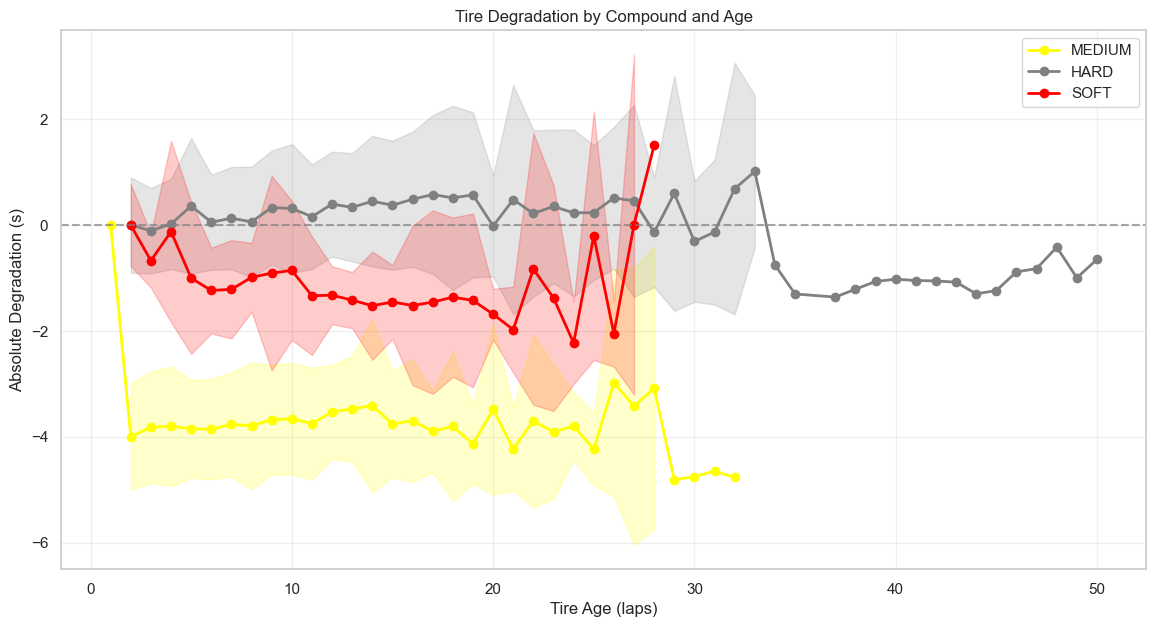

In [33]:
# Visualize the absolute degradation for all compounds
plt.figure(figsize=(14, 7))
compound_ids = tire_deg_data['CompoundID'].unique()

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['TireDegAbsolute'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Absolute Degradation (s)')
plt.title('Tire Degradation by Compound and Age')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_by_compound.png')
plt.show()

---

### 8.2 Tire Degradation Percentage

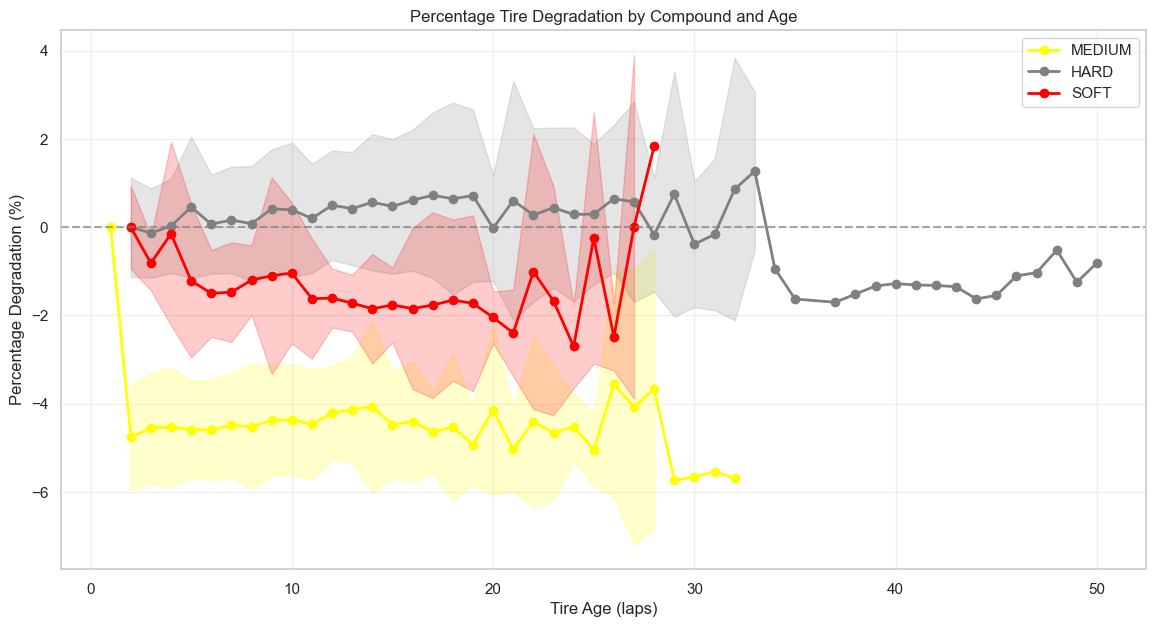

In [34]:
# Visualize the percentage degradation for all compounds
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['TireDegPercent'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Percentage Degradation (%)')
plt.title('Percentage Tire Degradation by Compound and Age')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_percent_by_compound.png')
plt.show()

---

### 8.3 Tire Degradation Rate

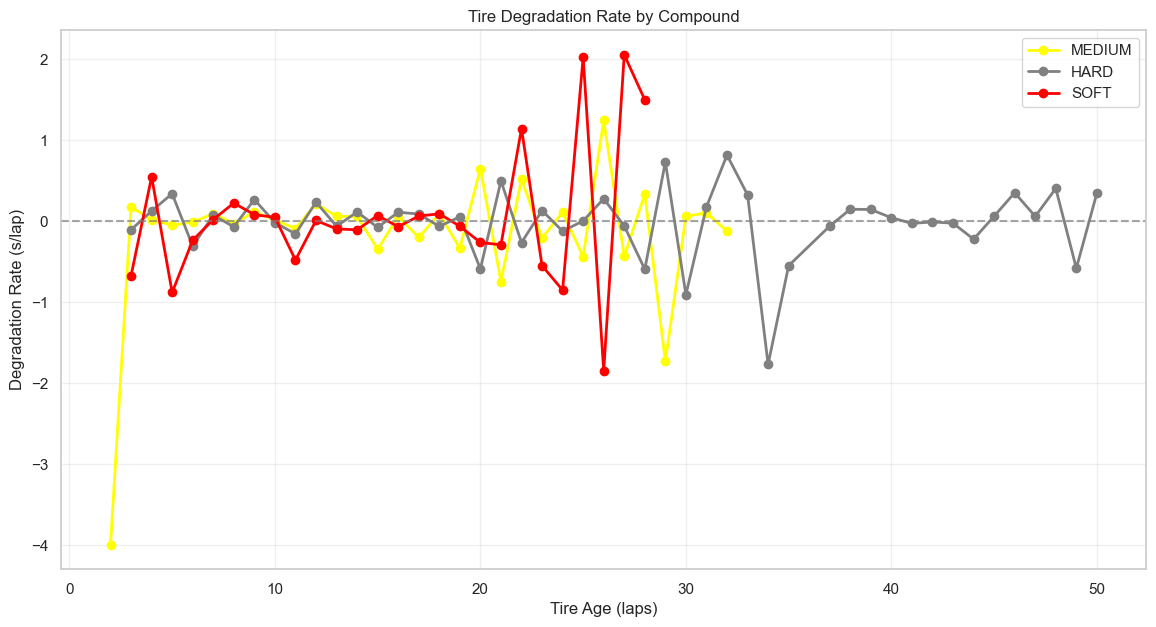

In [35]:

# Calculate degradation rate (change in seconds per lap) for each compound
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Calculate average lap time by tire age
    avg_laptimes = compound_subset.groupby('TyreAge')['LapTime'].mean()
    
    # Calculate lap-by-lap degradation rate
    deg_rates = avg_laptimes.diff()
    
    # Plot the degradation rate (change in seconds per lap)
    plt.plot(deg_rates.index[1:], deg_rates.values[1:], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Degradation Rate (s/lap)')
plt.title('Tire Degradation Rate by Compound')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_rate_by_compound.png')
plt.show()

---

## 9. Correlation Analysis: Tire-Related Factors with Lap Time

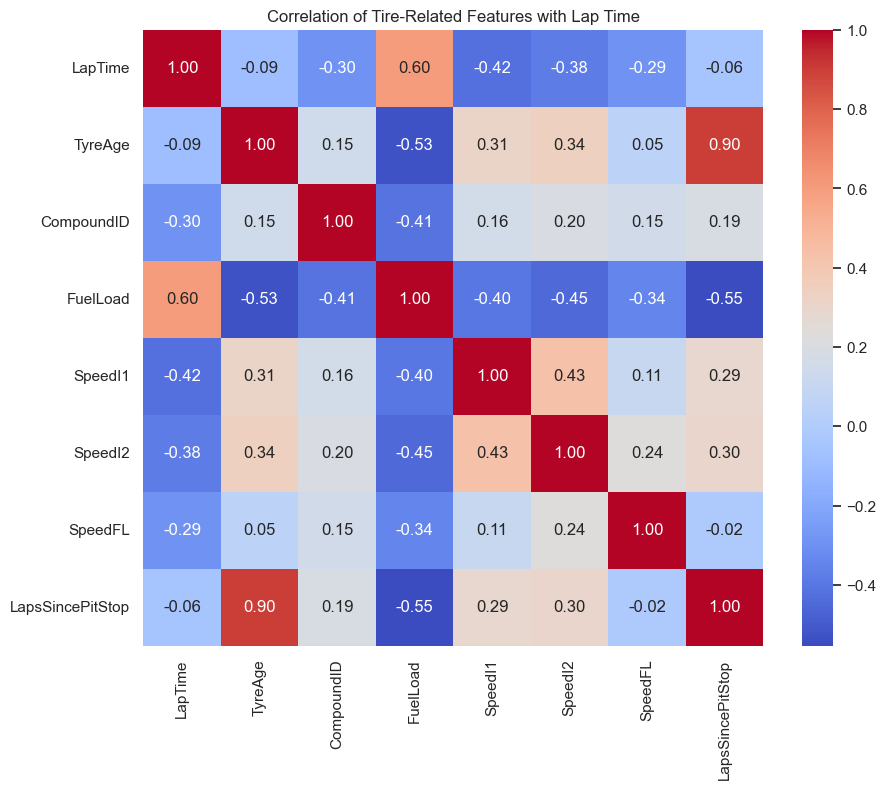

In [37]:
# Correlation analysis of tire-related factors with lap time
# Select relevant columns available in our dataset
selected_columns = ['LapTime', 'TyreAge', 'CompoundID', 'FuelLoad', 
                    'SpeedI1', 'SpeedI2', 'SpeedFL', 'LapsSincePitStop']

correlation = data[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Tire-Related Features with Lap Time')
plt.savefig('../../outputs/week5/tire_correlation.png')
plt.show()

---

## 10 Analyzing Difference between new and old tires

In [38]:
# Count how many laps are in each TyreAge category
tire_age_counts = data['TyreAge'].value_counts().sort_index()
print("Distribution of TyreAge values:")
display(tire_age_counts)

Distribution of TyreAge values:


TyreAge
1.0      1
2.0     43
3.0     43
4.0     48
5.0     57
6.0     56
7.0     56
8.0     55
9.0     57
10.0    52
11.0    50
12.0    51
13.0    51
14.0    52
15.0    50
16.0    50
17.0    47
18.0    45
19.0    40
20.0    38
21.0    37
22.0    35
23.0    29
24.0    26
25.0    23
26.0    21
27.0    15
28.0    11
29.0     8
30.0     6
31.0     5
32.0     4
33.0     2
34.0     1
35.0     1
37.0     1
38.0     1
39.0     1
40.0     1
41.0     1
42.0     1
43.0     1
44.0     1
45.0     1
46.0     1
47.0     1
48.0     1
49.0     1
50.0     1
Name: count, dtype: int64

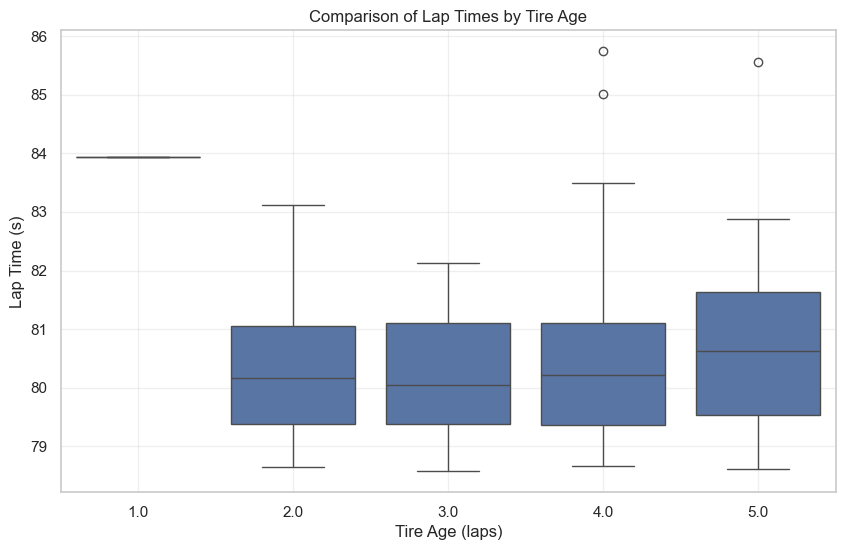

In [39]:
# Analyze the difference between a new tire and one with some laps on it
# This helps us understand the 'fresh tire effect'



# Compare lap times between fresh tires (TyreAge=1) and slightly used tires (TyreAge=2-3)
plt.figure(figsize=(10, 6))
sns.boxplot(x='TyreAge', y='LapTime', data=data[data['TyreAge'] <= 5])
plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Comparison of Lap Times by Tire Age')
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fresh_tire_effect.png')
plt.show()


In [40]:
# Calculate and display the average difference in lap time per additional lap on tires
agg_lap_times = data.groupby('TyreAge')['LapTime'].mean()
lap_time_diffs = agg_lap_times.diff().dropna()

print("\nAverage increase in lap time per additional lap on tires:")
display(lap_time_diffs)
print(f"Mean lap time increase per lap: {lap_time_diffs.mean():.4f} seconds")


Average increase in lap time per additional lap on tires:


TyreAge
2.0    -3.549419
3.0    -0.112419
4.0     0.269483
5.0     0.069880
6.0    -0.227473
7.0     0.064089
8.0     0.021621
9.0     0.194271
10.0   -0.066939
11.0   -0.228676
12.0    0.167325
13.0   -0.029176
14.0    0.047047
15.0   -0.129315
16.0    0.057860
17.0   -0.020139
18.0    0.015890
19.0   -0.122261
20.0   -0.103755
21.0   -0.072841
22.0    0.316746
23.0   -0.156248
24.0   -0.191744
25.0    0.183062
26.0    0.314321
27.0    0.046676
28.0   -0.243412
29.0   -0.107330
30.0   -0.803458
31.0    0.148333
32.0    0.559250
33.0    0.686750
34.0   -1.768000
35.0   -0.548000
37.0   -0.059000
38.0    0.149000
39.0    0.146000
40.0    0.044000
41.0   -0.026000
42.0   -0.008000
43.0   -0.023000
44.0   -0.221000
45.0    0.063000
46.0    0.353000
47.0    0.061000
48.0    0.406000
49.0   -0.580000
50.0    0.349000
Name: LapTime, dtype: float64

Mean lap time increase per lap: -0.0972 seconds
